In [17]:
import cirq
import numpy as np
import random as rand
import matplotlib.pyplot as plt

from cirq import Circuit
from cirq.devices import GridQubit
from cirq.google import XmonSimulator

# Quantum Compression


## Introduction
Goal: Simulate an Ising chain of $n$-qubits, using only $\log n$ qubits. Specifically, the paper does a four qubit Ising chain using two qubits. We must decompose the circuits for compressed simulation into the available gate set. We must also run the experiment often enough so that statistical errors are reduced. Systematic errors must be estimated using independent controlled circuits of similar complexity to the one of interest. Since we are running in simulation via Cirq, this may be less of an issue.

We use the following set up in Cirq for the rest of the tutorial:

In [3]:
qubits = cirq.LineQubit.range(3)
qubit0, qubit1, qubit2 = qubits

circuit = cirq.Circuit()

## Step 1
Prepare the input state $\rho_{i n} = \frac{1}{2^{m-1}} I^{\otimes m-1} \otimes |+_{y} \rangle \langle+_{y} |$ where $Y |+_{y} \rangle=|+_{y} \rangle$ by applying $S^{\dagger}H$ on qubit $0$, $H$ on an auxilirary qubit $2$, and $CNOT$ on qubits $1$ and $2$ with qubit $1$ being the target and qubit $2$ the control.

In [4]:
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.S(qubit0)**-1])
circuit.append([cirq.H(qubit2)])
circuit.append([cirq.CNOT(control=qubit2, target=qubit1)])

circuit

0: ───H───S^-1───

1: ───────X──────
          │
2: ───H───@──────

## Step 2

Evolve the system up to the desired value of $J$, which in this case is $J = 1$, by decomposing the evolutionary operator $W(J)=\prod_{l=1}^{L(J)} U_{d} R_{l}^{T} R_{0}^{T}$ into the Clifford+T gate set. This is done, rather than decomposing each step in the adiabatic evolution $U_{d} R_{l}^{T} R_{0}^{T}$, in order to keep the total circuit depth practically feasible.

In [5]:
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.CNOT(control=qubit0, target=qubit1)])
circuit.append([cirq.Z(qubit0)])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.CNOT(control=qubit0, target=qubit1)])
circuit.append([cirq.S(qubit0)])
circuit.append([cirq.T(qubit1)])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.Z(qubit1)])
circuit.append([cirq.CNOT(control=qubit0, target=qubit1)])
circuit.append([cirq.T(qubit0)])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)])

circuit

0: ───H───S^-1───H───@───Z───H───@───S───H───@───T───H───T───
                     │           │           │
1: ───────X──────────X───────────X───T───Z───X───────────────
          │
2: ───H───@──────────────────────────────────────────────────

Apply $(THS)^4$ on qubit $0$:

In [6]:
for _ in range(4):
    circuit.append([cirq.S(qubit0)])
    circuit.append([cirq.H(qubit0)])
    circuit.append([cirq.T(qubit0)])

circuit

0: ───H───S^-1───H───@───Z───H───@───S───H───@───T───H───T───S───H───T───S───H───T───S───H───T───S───H───T───
                     │           │           │
1: ───────X──────────X───────────X───T───Z───X───────────────────────────────────────────────────────────────
          │
2: ───H───@──────────────────────────────────────────────────────────────────────────────────────────────────

In [7]:
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)**-1])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)**-1])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)])
circuit.append([cirq.Z(qubit0)])
circuit.append([cirq.H(qubit0)])

circuit

0: ───H───S^-1───H───@───Z───H───@───S───H───@───T───H───T───S───H───T───S───H───T───S───H───T───S───H───T───H───T───H───T^-1───H───T^-1───H───T───Z───H───
                     │           │           │
1: ───────X──────────X───────────X───T───Z───X─────────────────────────────────────────────────────────────────────────────────────────────────────────────
          │
2: ───H───@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

## Step 3

Measure $Y$ on qubit $m$ to obtain the magnetization. In this case, $m = \log_{2}(4) - 1 = 1$. By nature of the rotation matrices in the matchgate circuit construction (Jozsa et al.), the $Z$ expectation of qubit $0$ after the circuit has completed $\langle Z_{0} \rangle$ is equal to the $Y$ expectation of qubit $m$ $\langle Y_{m} \rangle$, so a standard basis measurement made. Measuring the state $|0\rangle$ will correspond to an eigenvalue of $+1$ and the state $|1\rangle$ to an eigenvalue of $-1$. The expectation is equal to $\langle Y_{m} \rangle = -M(J)$, the magnetization as a function of $J$ (Hebenstreait et al.).

### Wave Function


Preserve the wave function of the system prior to measurement:

In [8]:
simulator = cirq.Simulator()
wave_function = simulator.simulate(circuit, qubit_order=qubits)

In [9]:
wave_function

measurements: (no measurements)
output vector: (-0.258-0.393j)|000⟩ + (0.393-0.258j)|001⟩ + (-0.096+0.46j)|010⟩ + (0.46+0.096j)|011⟩ + (-0.133+0.107j)|100⟩ + (-0.107-0.133j)|101⟩ + (0.169+0.018j)|110⟩ + (0.018-0.169j)|111⟩

Calculate the magnetization $M(J)$ from the wave function by decomposing the final state into the $+1$ and $-1$ eigenstates, determining the total probability for each, and computing the expectation $\langle Y_{m} \rangle$:

In [10]:
final_state = wave_function.final_state

p_1_wfn = (sum([np.absolute(i)**2 for i in final_state[0:4]]))
p_n1_wfn = (sum([np.absolute(i)**2 for i in final_state[4:8]]))

Y_wfn = 1 * p_1_wfn + -1 * p_n1_wfn

M_wfn = -Y_wfn
M_wfn

-0.7683054202225357

# Measured Outcome

Apply the standard basis measurement operator to qubit $0$:

In [11]:
circuit.append([cirq.measure(qubit0, key='x')])
circuit

0: ───H───S^-1───H───@───Z───H───@───S───H───@───T───H───T───S───H───T───S───H───T───S───H───T───S───H───T───H───T───H───T^-1───H───T^-1───H───T───Z───H───M('x')───
                     │           │           │
1: ───────X──────────X───────────X───T───Z───X──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          │
2: ───H───@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Repeatedly run the circuit for $n=1,000,000$ iterations:

In [12]:
n = 1000000
results = simulator.run(circuit, repetitions=n)
results

x=00000000001001000000000000001000000001000000001010010100001000100000000100000000100000000000001000000000000000000000000000100000000100001010000000100100000000000000000000010000001000000000000000000000000000000010000000000000110000000000000000101000000000000000000100000010000000000000001000100000000000000000000000000000000000000010000000000000000000010000000000000000001001000000100101000001000000000100000000000011000001100010100010000000000100000000100000010010000001000000000010000100000000000000000000000000000000000000001000000000000001010100000010000000000000000000000000000000100000000000000000001000010000000000100000000000000010001000000100000000000100001000000000000000000000001000000000000000000000010000000001000000000000001000000001010000000000000000010010000000001000001000000000000000100110000000000000100000000010010000000001001100000000000100010000000001000001000010000001000000000000000010000001100000000000000000000000000000000000000010001001010000000000000000001000000000000000

Counter({0: 884238, 1: 115762})


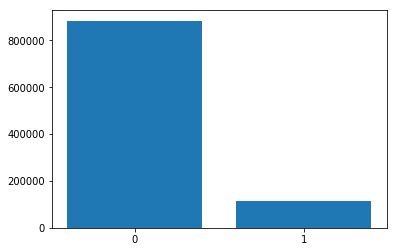

In [13]:
hist = results.histogram(key='x')

for k in hist:
    v = hist[k]
    hist[k] = v
    
print(hist)

plt.bar(range(len(hist)), hist.values(), align='center')
plt.xticks(range(len(hist)), list(hist.keys()))

plt.show()

Calculate the magnetization $M(J)$ from the measured outcomes by determining the relative frequency of each eigenstate and computing the expectation $\langle Y_{m} \rangle$:

In [14]:
f_1_meas = hist[0] / n
f_n1_meas = hist[1] / n

Y_meas = 1 * f_1_meas - 1 * f_n1_meas

M_meas = - Y_meas
M_meas

-0.7684759999999999

# Final Results
We can now compare our three results: the measured outcomes (finite number of runs), the wave function (limit of infinite runs), and the theoretical prediction given by the Ising model (Hebenstreait et al.):

In [15]:
M_theor = -0.81

err_wfn = 100 * (M_theor - M_wfn) / M_theor
err_meas = 100 * (M_theor - M_meas) / M_theor

err_wfn, err_meas

(5.147478984872145, 5.1264197530864335)

Both of our results have about 5% error, which is consistent with the results of Hebenstreait et al. for a four-qubit spin chain simulation.


In [122]:
def ising_circuit(n, J, Jmax, L, dt):
    m = int(np.log2(n)) + 1
    qubits = cirq.LineQubit.range(m)
    circuit = cirq.Circuit()
    
    circuit.append([cirq.X(qubits[m - 1])])    
    circuit.append([cirq.H(qubits[m - 1])])
    circuit.append([cirq.S(qubits[m - 1])])
    
    #depolarizing channel
    for i in range(1, m):
        x = rand.randint(0, 1)
        if x:
            circuit.append([cirq.X(qubits[i])])
    
    def R0():
        R0 = cirq.Ry(-4 * dt)
        circuit.append([R0.on(qubits[m - 1])])
    
    LJ = int(J * L / Jmax)
    for l in range(0, LJ):
        Jl = Jmax * l / L
        
        def Rl():
            phil = 2 * Jl * dt
            r = cirq.SingleQubitMatrixGate(np.array([[np.cos(phil), -np.sin(phil)], [np.sin(phil), np.cos(phil)]]))
            circuit.append([r.on(qubits[m - 1])])
            #for q in range(m):
                #circuit.append([r.on(qubits[q])])
            
            Cr = cirq.ControlledGate(r**-1, qubits[0:m-1], m - 1)
            circuit.append([Cr.on(qubits[m - 1])])
            
        R0()
        Rl()
    
    circuit.append([cirq.S(qubits[0])**-1])
    circuit.append([cirq.H(qubits[0])])
    circuit.append([cirq.measure(qubit0, key='x')])
    return circuit
    
            
ising_circuit(8, 1, 2 ,10, 1)

┌       ┐   ┌             ┐                     ┌             ┐   ┌                     ┐                     ┌             ┐   ┌                     ┐                     ┌             ┐   ┌                     ┐                     ┌             ┐   ┌                     ┐
0: ───X───────────H───────────S───Ry(-1.273π)───│ 1. -0.│───│1.+0.j 0.+0.j│───Ry(-1.273π)───────│ 0.921 -0.389│───│ 0.921+0.j  0.389+0.j│───Ry(-1.273π)───────│ 0.697 -0.717│───│ 0.697+0.j  0.717+0.j│───Ry(-1.273π)───────│ 0.362 -0.932│───│ 0.362+0.j  0.932+0.j│───Ry(-1.273π)───────│-0.029 -1.   │───│-0.029+0.j  1.   +0.j│───S^-1───H───M('x')───
                                                │ 0.  1.│   │0.+0.j 1.+0.j│                     │ 0.389  0.921│   │-0.389+0.j  0.921+0.j│                     │ 0.717  0.697│   │-0.717+0.j  0.697+0.j│                     │ 0.932  0.362│   │-0.932+0.j  0.362+0.j│                     │ 1.    -0.029│   │-1.   +0.j -0.029+0.j│
                                                └       ┘   └             ┘                     └             ┘   └                     ┘                     └             ┘   └                     ┘                     └             ┘   └                     ┘                     └             ┘   └                     ┘
                                                            │                                                     │                                                             │                                                             │                                                             │
                  ┌       ┐                                 │                 ┌             ┐                     │                         ┌             ┐                     │                         ┌             ┐                     │                         ┌             ┐                     │
1: ───X───────────│ 1. -0.│─────────────────────────────────@─────────────────│ 0.921 -0.389│─────────────────────@─────────────────────────│ 0.697 -0.717│─────────────────────@─────────────────────────│ 0.362 -0.932│─────────────────────@─────────────────────────│-0.029 -1.   │─────────────────────@─────────────────────────────────────────────
                  │ 0.  1.│                                 │                 │ 0.389  0.921│                     │                         │ 0.717  0.697│                     │                         │ 0.932  0.362│                     │                         │ 1.    -0.029│                     │
                  └       ┘                                 │                 └             ┘                     │                         └             ┘                     │                         └             ┘                     │                         └             ┘                     │
                                                            │                                                     │                                                             │                                                             │                                                             │
      ┌       ┐                                             │                 ┌             ┐                     │                         ┌             ┐                     │                         ┌             ┐                     │                         ┌             ┐                     │
2: ───│ 1. -0.│─────────────────────────────────────────────@─────────────────│ 0.921 -0.389│─────────────────────@─────────────────────────│ 0.697 -0.717│─────────────────────@─────────────────────────│ 0.362 -0.932│─────────────────────@─────────────────────────│-0.029 -1.   │─────────────────────@─────────────────────────────────────────────
      │ 0.  1.│                                                               │ 0.389  0.921│                                               │ 0.717  0.697│                                               │ 0.932  0.362│      

In [120]:
simulator = cirq.Simulator()

result_new = simulator.run(ising_circuit(8, 1, 2 ,10, 1) , repetitions=1000000)
result_new

x=11111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111

Counter({1: 1000000})


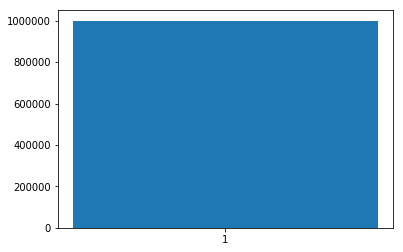

In [121]:
hist = result_new.histogram(key='x')

for k in hist:
    v = hist[k]
    hist[k] = v
    
print(hist)

plt.bar(range(len(hist)), hist.values(), align='center')
plt.xticks(range(len(hist)), list(hist.keys()))

plt.show()